In [2]:
import osmnx as ox

In [3]:
ox.config(use_cache=True, log_console=True)

In [14]:
graph = ox.graph_from_bbox(48.1510, 48.1249, 11.5430, 11.6104, network_type='walk', simplify=True, retain_all=False)

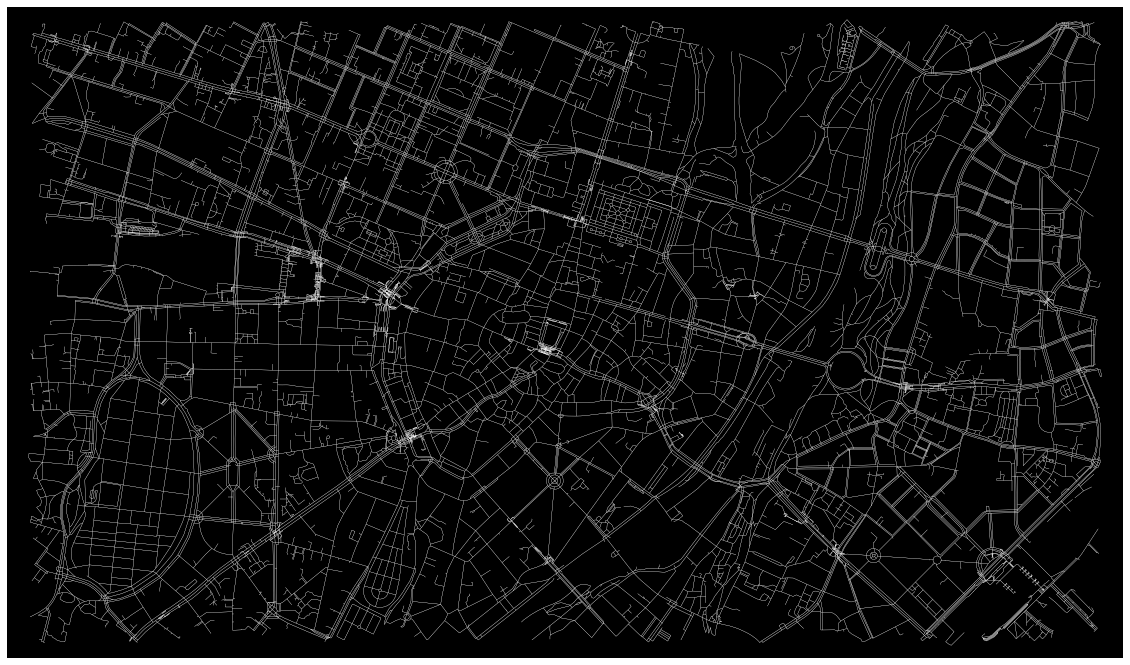

In [26]:
fig, ax = ox.plot_graph(graph, node_size=0, edge_color='w', edge_linewidth=0.2, bgcolor='k', figsize=(20, 20), dpi=10000)

In [24]:
basic_stats = ox.basic_stats(graph)
extended_stats = ox.extended_stats(graph)

C:\Users\Sombra Negra\anaconda3\lib\site-packages\osmnx\stats.py:458: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


In [18]:
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)

In [25]:
extended_stats

{'avg_neighbor_degree': {277381: 4.0,
  277382: 3.75,
  277383: 3.2,
  277384: 3.25,
  277385: 3.25,
  277386: 3.5,
  277387: 3.0,
  277388: 4.0,
  295122: 4.0,
  295141: 3.0,
  295209: 4.0,
  361774: 3.6666666666666665,
  361775: 3.6666666666666665,
  361776: 3.6666666666666665,
  361779: 4.25,
  361780: 4.0,
  361786: 4.0,
  361790: 4.0,
  361791: 4.0,
  361793: 3.6666666666666665,
  361797: 3.0,
  361798: 3.25,
  361799: 3.6666666666666665,
  361802: 4.0,
  361803: 4.0,
  363161: 2.8,
  363166: 3.25,
  363169: 4.0,
  363187: 3.6666666666666665,
  363189: 4.0,
  363191: 3.25,
  363192: 3.3333333333333335,
  363193: 3.3333333333333335,
  363194: 3.3333333333333335,
  363197: 3.25,
  398664: 2.6666666666666665,
  398714: 3.5,
  398732: 3.4,
  398753: 3.0,
  398764: 4.0,
  398811: 4.25,
  428756: 3.75,
  428757: 4.25,
  428767: 3.6666666666666665,
  428771: 3.5,
  428777: 3.75,
  428779: 3.75,
  428781: 4.0,
  428782: 4.333333333333333,
  428785: 4.0,
  564445: 3.6666666666666665,
  564